In [59]:
!pip install pyarrow==15.0.2 datasets seaborn nltk

In [60]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

# **Data Pre Processing**

In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import string
from tqdm import tqdm
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, \
roc_auc_score, roc_curve, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

In [62]:
# Loading the dataset
df = pd.read_csv('/content/AllBeautyProcessed_AmazonReviews.csv')
#Let's check the samples of data
df.head()

,overall,reviewText
0,positive,i was looking for brushes online and these wor...
1,positive,super cute earrings delivery was faster than e...
2,positive,the title says it all best dry shaver availab...
3,negative,this tape breaks during usage very easily it ...
4,positive,i wanted something to make it easier to pee wh...


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88609 entries, 0 to 88608
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   overall     88609 non-null  object
 1   reviewText  88581 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


# Cleaning

In [64]:
original_df = df.copy(deep=True)
df.head()

,overall,reviewText
0,positive,i was looking for brushes online and these wor...
1,positive,super cute earrings delivery was faster than e...
2,positive,the title says it all best dry shaver availab...
3,negative,this tape breaks during usage very easily it ...
4,positive,i wanted something to make it easier to pee wh...


In [65]:
#Dimentions of the dataset & information about dataset
print('Dimentions of dataset:', df.shape)
#Checking the dtypes of all the columns
df.info()

Dimentions of dataset: (88609, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88609 entries, 0 to 88608
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   overall     88609 non-null  object
 1   reviewText  88581 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [66]:
#Descriptive summary of dataset
df.describe()

,overall,reviewText
count,88609,88581
unique,3,81438
top,neutral,good
freq,29540,274


In [67]:
#Let's check Null values
df.isnull().sum()

,0
overall,0
reviewText,28


In [68]:
#Dropping the null values
df.dropna(inplace=True)
original_df = df.copy()

In [69]:
#Let's check Duplicates
df.duplicated().sum()

6781

In [70]:
duplicates = df[df.duplicated()]
duplicates

,overall,reviewText
226,neutral,ok
234,neutral,it was ok
420,neutral,ok
484,positive,love it
525,positive,love it
...,...,...
88589,negative,junk
88591,neutral,good
88592,neutral,this product does have a nasty smell to it so ...
88594,negative,i use hot air brushes and a good one is hard t...


In [71]:
# Remove duplicate rows
df = df.drop_duplicates()

In [72]:
#Let's check Null values
df.isnull().sum()

,0
overall,0
reviewText,0


In [73]:
#Let's check Duplicates
df.duplicated().sum()

0

In [74]:
# Let's get a word count
df['word_count'] = df['reviewText'].apply(lambda x: len(str(x).split(" ")))
df[['reviewText','word_count']].head()

,reviewText,word_count
0,i was looking for brushes online and these wor...,66
1,super cute earrings delivery was faster than e...,11
2,the title says it all best dry shaver availab...,23
3,this tape breaks during usage very easily it ...,24
4,i wanted something to make it easier to pee wh...,53


In [75]:
#Number of Characters- including spaces
df['char_count'] = df['reviewText'].str.len() # this also includes spaces
df[['reviewText','char_count']].head()


,reviewText,char_count
0,i was looking for brushes online and these wor...,296
1,super cute earrings delivery was faster than e...,69
2,the title says it all best dry shaver availab...,112
3,this tape breaks during usage very easily it ...,111
4,i wanted something to make it easier to pee wh...,242


In [76]:
#Number of stop Words:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['stopwords'] = df['reviewText'].apply(lambda x: len([x for x in x.split() if x in stop]))
df[['reviewText','stopwords']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,reviewText,stopwords
0,i was looking for brushes online and these wor...,34
1,super cute earrings delivery was faster than e...,3
2,the title says it all best dry shaver availab...,8
3,this tape breaks during usage very easily it ...,12
4,i wanted something to make it easier to pee wh...,28


In [77]:
#Number of special character:
df['hastags'] = df['reviewText'].apply(lambda x: len([x for x in x.split() if x.startswith('@')]))
df[['reviewText','hastags']].head()

,reviewText,hastags
0,i was looking for brushes online and these wor...,0
1,super cute earrings delivery was faster than e...,0
2,the title says it all best dry shaver availab...,0
3,this tape breaks during usage very easily it ...,0
4,i wanted something to make it easier to pee wh...,0


In [78]:
#Number of numerics:
df['numerics'] = df['reviewText'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df[['reviewText','numerics']].head()

,reviewText,numerics
0,i was looking for brushes online and these wor...,0
1,super cute earrings delivery was faster than e...,0
2,the title says it all best dry shaver availab...,0
3,this tape breaks during usage very easily it ...,0
4,i wanted something to make it easier to pee wh...,0


WORDCLOUD

In [79]:
pip install wordcloud

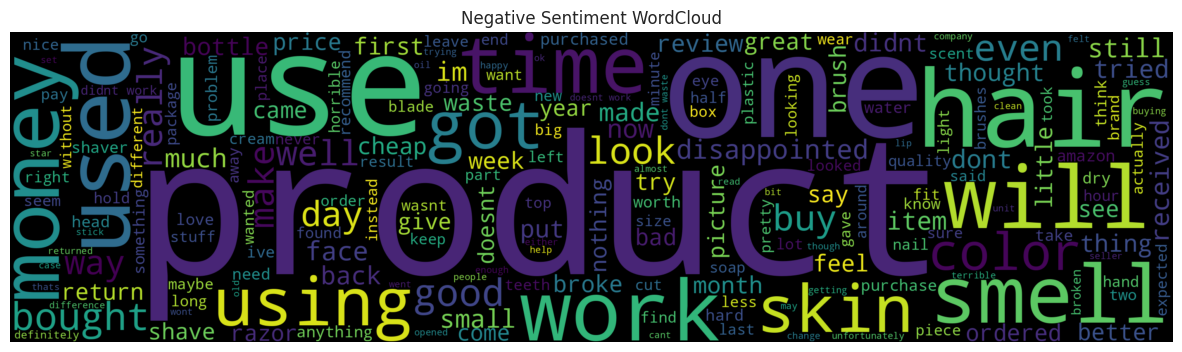

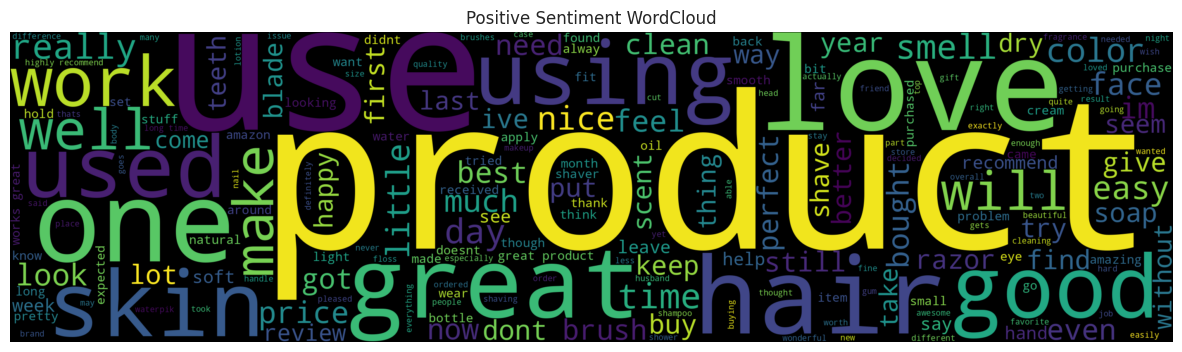

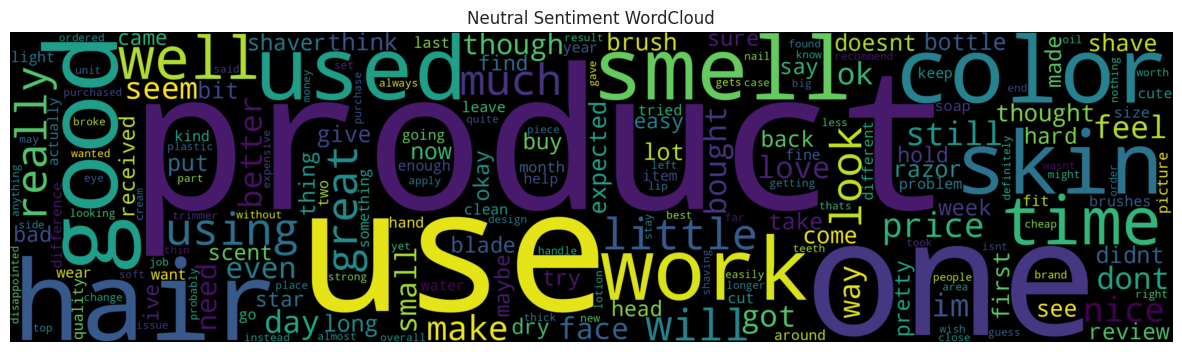

In [80]:
from wordcloud import WordCloud, STOPWORDS
negative_df = df[df['overall'] == 'negative']
positive_df = df[df['overall'] == 'positive']
neutral_df = df[df['overall'] == 'neutral']

# Define a function to generate and display a WordCloud
def generate_wordcloud(data, title):
    words = ' '.join(data['reviewText'])
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT' ])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='black',
                          width=3000, height=800).generate(cleaned_word)
    plt.figure(figsize=(15, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
# Generate and display WordClouds for each sentiment category
generate_wordcloud(negative_df, 'Negative Sentiment WordCloud')
generate_wordcloud(positive_df, 'Positive Sentiment WordCloud')
generate_wordcloud(neutral_df, 'Neutral Sentiment WordCloud')


BASIC PREPROCESSING

In [81]:
!pip install nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
# Convert text to lowercase
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Removal of punctuations
df['reviewText'].str.replace('[^\w\s]','')

from nltk.corpus import stopwords
stop = stopwords.words('english')
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['reviewText'].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,reviewText
0,looking brushes online work really good super ...
1,super cute earrings delivery faster expected g...
2,title says best dry shaver available light sha...
3,tape breaks usage easily usually takes quantit...
4,wanted something make easier pee go camping ra...


COMMON WORDS REMOVAL

In [82]:
freq = pd.Series(' '.join(df['reviewText']).split()).value_counts()[:30]
freq

,count
product,22151
like,18377
use,15830
hair,14453
one,13848
good,12546
would,12188
great,11867
get,10691
skin,10541


Let's remove "I'm", '-', '****', '& '
There can be other words too which can be removed, but let's conbtinue with above only

In [83]:
freq =["im", "-", "****", "&"]
df['reviewText']= df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df['reviewText'].head()

,reviewText
0,looking brushes online work really good super ...
1,super cute earrings delivery faster expected g...
2,title says best dry shaver available light sha...
3,tape breaks usage easily usually takes quantit...
4,wanted something make easier pee go camping ra...


In [84]:
#Rare Words Removal
#This is done as association of these less occurring words with the existing words could be a noise
freq = pd.Series(' '.join(df['reviewText']).split()).value_counts()[-10:]
freq

,count
idecorative,1
fuxed,1
unomfortable,1
unrewarded,1
symbolize,1
framework,1
comfartibility,1
scoring,1
sume,1
firstwell,1


In [85]:
#Stemming -refers to the removal of suffices, like “ing”, “ly”, “s”, etc. by a simple rule-based approach¶
from nltk.stem import PorterStemmer
st = PorterStemmer()
df['reviewText'][:5].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

,reviewText
0,look brush onlin work realli good super soft c...
1,super cute ear deliveri faster expect gotta love
2,titl say best dri shaver avail light shave out...
3,tape break usag easili usual take quantiti mou...
4,want someth make easier pee go camp rave tomor...


In [86]:
df['overall'].value_counts()

,count
overall,
negative,28010
neutral,27145
positive,26645


                 Sentiment Variable Distribution                  


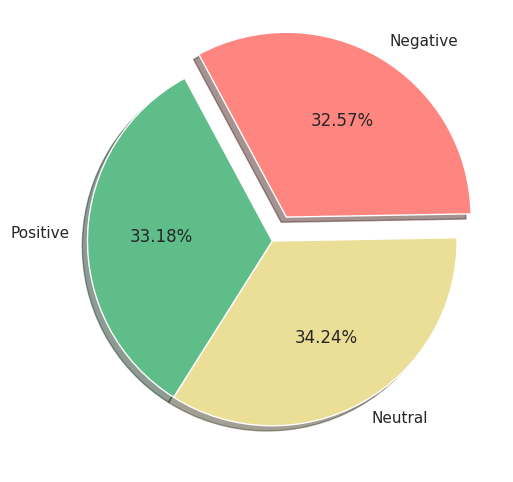

In [87]:
#Let's look at the overall distribution of positive, negative and neutral sentiments
print('\033[1mSentiment Variable Distribution'.center(70))
plt.figure(figsize=(12, 6))
colors = ['#ebde96', '#5ebd89', '#ff8680']
plt.pie(df['overall'].value_counts(), labels=['Neutral', 'Positive', 'Negative'], counterclock=False, shadow=True,
        explode=[0, 0, 0.15], autopct='%1.2f%%', radius=1, startangle=1, colors=colors)

plt.show()

In [88]:
df.head()

,overall,reviewText,word_count,char_count,stopwords,hastags,numerics
0,positive,looking brushes online work really good super ...,66,296,34,0,0
1,positive,super cute earrings delivery faster expected g...,11,69,3,0,0
2,positive,title says best dry shaver available light sha...,23,112,8,0,0
3,negative,tape breaks usage easily usually takes quantit...,24,111,12,0,0
4,positive,wanted something make easier pee go camping ra...,53,242,28,0,0


In [89]:
#Number of stop Words:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['stopwords'] = df['reviewText'].apply(lambda x: len([x for x in x.split() if x in stop]))
df[['reviewText','stopwords']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,reviewText,stopwords
0,looking brushes online work really good super ...,0
1,super cute earrings delivery faster expected g...,0
2,title says best dry shaver available light sha...,0
3,tape breaks usage easily usually takes quantit...,0
4,wanted something make easier pee go camping ra...,0


In [90]:
df['stopwords'].value_counts()

,count
stopwords,
0,81800


In [91]:
# Let's get a word count
df['word_count'] = df['reviewText'].apply(lambda x: len(str(x).split(" ")))
df[['reviewText','word_count']].head()

,reviewText,word_count
0,looking brushes online work really good super ...,28
1,super cute earrings delivery faster expected g...,8
2,title says best dry shaver available light sha...,11
3,tape breaks usage easily usually takes quantit...,9
4,wanted something make easier pee go camping ra...,25


In [92]:
# Sort by word_count in descending order and display the top rows
sorted_df = df[['reviewText', 'word_count']].sort_values(by='word_count', ascending=False).head(20)
sorted_df

,reviewText,word_count
53050,many things unspecialized people must aware pu...,1078
56405,got razor christmas gift telling girlfriend fr...,882
65256,review two parts brief version top people want...,866
64138,essence part skii line products classified rad...,805
25786,arcitec cc essentially plus cleaning station h...,724
6093,pitera stuff skii markets unique active ingred...,709
32032,review astra blade contained herein heres shav...,683
47611,first work sweetsation therapy wish recently m...,669
47547,first bought norelco rotating reflex head shav...,632
14085,ive rotary guy years always liked philips shav...,627


In [93]:
df[['reviewText','word_count']].head()

,reviewText,word_count
0,looking brushes online work really good super ...,28
1,super cute earrings delivery faster expected g...,8
2,title says best dry shaver available light sha...,11
3,tape breaks usage easily usually takes quantit...,9
4,wanted something make easier pee go camping ra...,25


In [94]:
token_lens = []
from transformers import BertTokenizer
tokenizer= BertTokenizer.from_pretrained('bert-base-uncased')
for txt in df.reviewText:
  tokens = tokenizer.encode(txt, max_length=1100)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


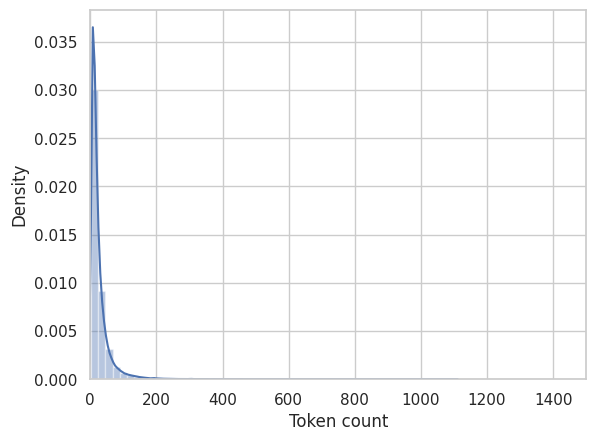

In [95]:
sns.distplot(token_lens)
plt.xlim([0, 1500]);
plt.xlabel('Token count');

In [96]:
df.head()

,overall,reviewText,word_count,char_count,stopwords,hastags,numerics
0,positive,looking brushes online work really good super ...,28,296,0,0,0
1,positive,super cute earrings delivery faster expected g...,8,69,0,0,0
2,positive,title says best dry shaver available light sha...,11,112,0,0,0
3,negative,tape breaks usage easily usually takes quantit...,9,111,0,0,0
4,positive,wanted something make easier pee go camping ra...,25,242,0,0,0


In [97]:
# Modify the original DataFrame
df = df[df['word_count'] <= 510]

In [98]:
# Sort by word_count in descending order and display the top rows
sorted_df = df[['reviewText', 'word_count']].sort_values(by='word_count', ascending=False).head(100)
print(sorted_df)

                                              reviewText  word_count
9681   always huge fan braun products build quality d...         504
50822  whole life ive needed use hair straightener th...         491
10254  recently tortured hair bleachings multiple dye...         478
32146  great little shaver recommend used blade years...         474
6133   typically dont sport beard decided grow one mo...         455
...                                                  ...         ...
56879  ive owned shavers last years recent norelco ar...         271
44584  become difficult find stores almost everything...         269
50024  please read update update update week update l...         269
46265  edit awarded seven minerals second star based ...         268
50619  items look neat tried install old cast iron ha...         267

[100 rows x 2 columns]


In [99]:
token_lens = []
from transformers import BertTokenizer
tokenizer= BertTokenizer.from_pretrained('bert-base-uncased')
for txt in df.reviewText:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


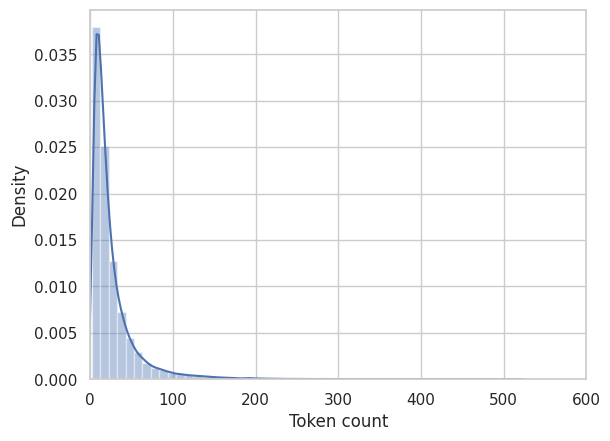

In [100]:
sns.distplot(token_lens)
plt.xlim([0, 600]);
plt.xlabel('Token count');

In [101]:
df = df[['reviewText', 'overall']]

In [102]:
df.head()

,reviewText,overall
0,looking brushes online work really good super ...,positive
1,super cute earrings delivery faster expected g...,positive
2,title says best dry shaver available light sha...,positive
3,tape breaks usage easily usually takes quantit...,negative
4,wanted something make easier pee go camping ra...,positive


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81782 entries, 0 to 88608
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  81782 non-null  object
 1   overall     81782 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


AGAIN visualize after cleaning

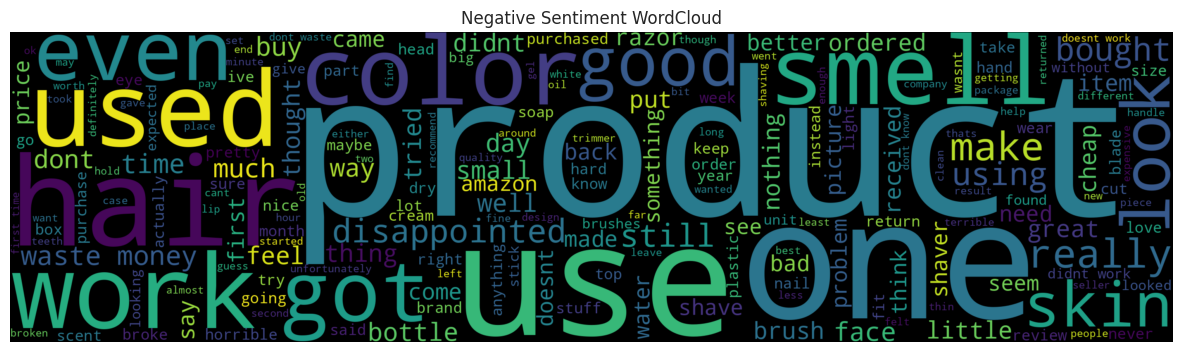

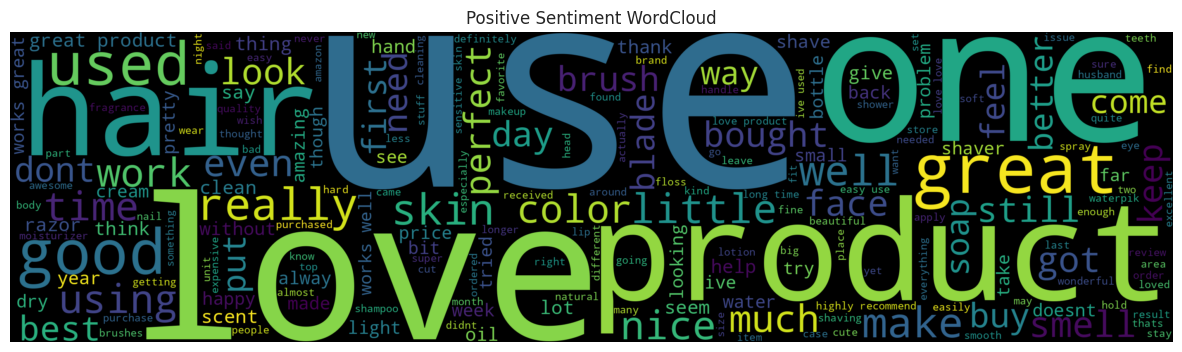

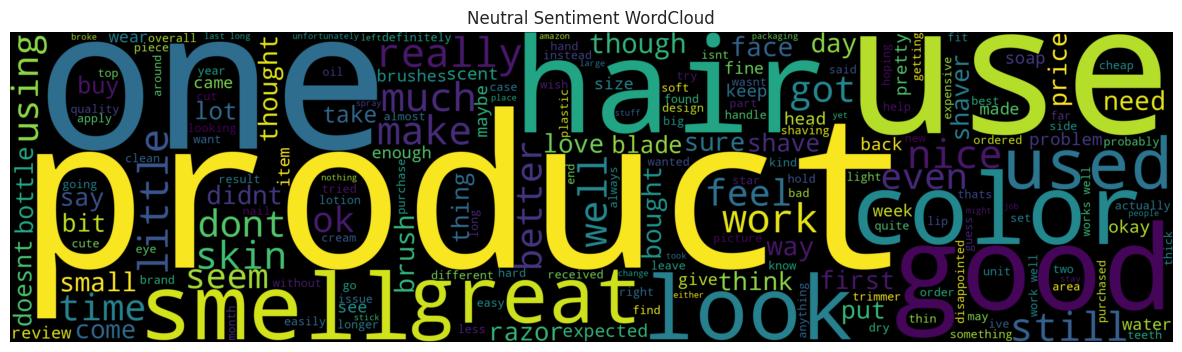

In [104]:
from wordcloud import WordCloud, STOPWORDS
negative_df = df[df['overall'] == 'negative']
positive_df = df[df['overall'] == 'positive']
neutral_df = df[df['overall'] == 'neutral']

# Define a function to generate and display a WordCloud
def generate_wordcloud(data, title):
    words = ' '.join(data['reviewText'])
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT' ])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='black',
                          width=3000, height=800).generate(cleaned_word)
    plt.figure(figsize=(15, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
# Generate and display WordClouds for each sentiment category
generate_wordcloud(negative_df, 'Negative Sentiment WordCloud')
generate_wordcloud(positive_df, 'Positive Sentiment WordCloud')
generate_wordcloud(neutral_df, 'Neutral Sentiment WordCloud')


# **BERT Model**

In [53]:
label_mapping = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

# Step 3: Apply the mapping to the review column
# Replace 'review_column' with the actual name of your review column
df['overall'] = df['overall'].map(label_mapping)

In [54]:
# Install all necessary libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and text handling
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Deep Learning libraries (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

# Transformers for BERT
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset

# Word Embeddings
import gensim

# NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization Settings
sns.set(style='whitegrid')

# Setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Load the pre-trained BERT tokenizer and model
tokenizer= BertTokenizer.from_pretrained('bert-base-uncased')
model= BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3) # 3 sentiment classes

# Encode the text data using the tokenizer
encoded_data= tokenizer.batch_encode_plus(df['reviewText'].tolist(), max_length=512, padding=True, truncation=True, return_tensors='pt')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Split the data into training and test sets for BERT
input_ids= encoded_data['input_ids']
attention_masks= encoded_data['attention_mask']
# labels= torch.tensor(df['sentiment'].map({'positive': 0, 'negative': 1, 'neutral': 2}).values)
labels = torch.tensor(df['overall'].values)

train_inputs, val_inputs, train_labels, val_labels= train_test_split(input_ids, labels, test_size= 0.2, random_state= 42)
train_masks, val_masks, _, _= train_test_split(attention_masks, input_ids, test_size= 0.2, random_state= 42)

In [ ]:
# Convert your data into the required format for the Dataset object
def convert_to_dataset(input_ids, attention_masks, labels):
    dataset = Dataset.from_dict({
        'input_ids': input_ids.numpy(),
        'attention_mask': attention_masks.numpy(),
        'labels': labels.numpy()
    })
    return dataset

In [ ]:
# Create the training and validation datasets
train_dataset= convert_to_dataset(train_inputs, train_masks, train_labels)
val_dataset= convert_to_dataset(val_inputs, val_masks, val_labels)

In [ ]:
# Use a data collator to handle padding
data_collator= DataCollatorWithPadding(tokenizer)

# Set up the training arguments
training_args= TrainingArguments(output_dir='./bert_output', num_train_epochs=1, per_device_train_batch_size=32, per_device_eval_batch_size=32, warmup_steps=500, weight_decay=0.01, logging_dir='./logs', report_to= 'none')

In [ ]:
# Create the trainer
trainer= Trainer(model= model, args= training_args, train_dataset= train_dataset, eval_dataset= val_dataset, data_collator= data_collator, tokenizer= tokenizer)

# Train the model
trainer.train()

Step,Training Loss
500,0.878100
1000,0.719500


Step,Training Loss
500,0.878100
1000,0.719500
1500,0.668700
2000,0.646000


TrainOutput(global_step=2045, training_loss=0.7263977274626566, metrics={'train_runtime': 5924.1706, 'train_samples_per_second': 11.044, 'train_steps_per_second': 0.345, 'total_flos': 1.72141953548544e+16, 'train_loss': 0.7263977274626566, 'epoch': 1.0})

In [ ]:
# Evaluate the BERT model
model.eval()
predictions= []
true_labels= []
mis_predictions_data = []  # List to store mispredictions

In [ ]:
# Create a DataLoader for the validation set
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=32)

In [ ]:
# Make predictions on the validation set
with torch.no_grad():
    for batch in val_dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
        outputs = model(**inputs)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = batch[2].to('cpu').numpy()

        # Get predicted labels
        pred_labels = np.argmax(logits, axis=1)

        # Extend the lists with current batch predictions and true labels
        predictions.extend(pred_labels)
        true_labels.extend(label_ids)

        # Identify mispredictions
        mis_pred_indices = np.where(pred_labels != label_ids)[0]

        # Collect misprediction data
        for i in mis_pred_indices:
            # Extract the relevant input data
            input_ids = batch[0][i].cpu().numpy()
            attention_mask = batch[1][i].cpu().numpy()
            true_label = label_ids[i]
            predicted_label = pred_labels[i]

            # Convert input_ids to text
            decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)

            # Store the misprediction data with the decoded text
            mis_pred_data = {
                'text': decoded_text,
                'true_label': true_label,
                'predicted_label': predicted_label
            }
            mis_predictions_data.append(mis_pred_data)

In [ ]:
# mis_predictions_data


[{'text': 'arent see pictured edges squared big picture appears one lot defects stone concave edge',
  'true_label': 1,
  'predicted_label': 0},
 {'text': 'giving product due mess makes could lack coordination skills purchased son recently got braceswell needless say makes mess bathroom whoever using lol think product takes getting used',
  'true_label': 2,
  'predicted_label': 0},
 {'text': 'nice price', 'true_label': 1, 'predicted_label': 2},
 {'text': 'wax container damaged wax leaked probably returned whole kit',
  'true_label': 1,
  'predicted_label': 0},
 {'text': 'ever since phillips bought norelco magnavox brands used put high qualityvalue list dissapointing common denominator philips name said like flexible nature head razor doesnt seem power blades well cuts beard pretty well done daily price gets stars shopped around bought lowest price could find around beware sellers charged much range remember expected quality main plus works pretty well even use shower last razor didnt w

In [ ]:
# Calculate evaluation metrics for BERT
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'BERT - Accuracy: {accuracy:.2f}')
print(f'BERT - Precision: {precision:.2f}')
print(f'BERT - Recall: {recall:.2f}')
print(f'BERT - F1 Score: {f1:.2f}')

BERT - Accuracy: 0.73
BERT - Precision: 0.72
BERT - Recall: 0.73
BERT - F1 Score: 0.73


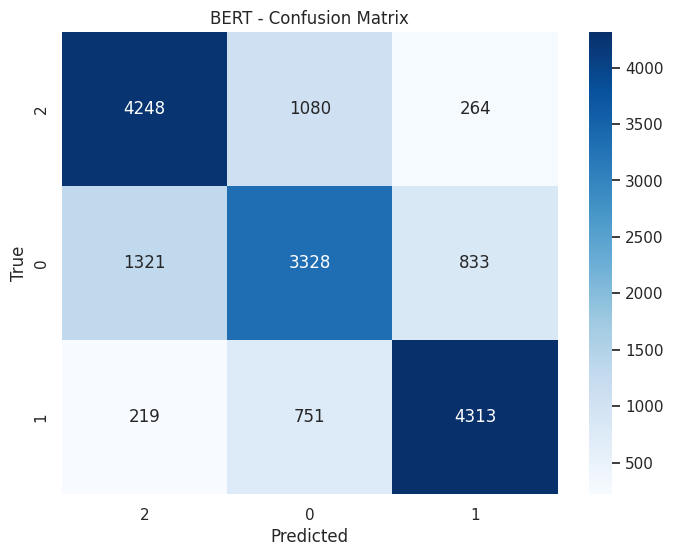

In [ ]:
# Generate and plot the confusion matrix for BERT
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['overall'].unique(), yticklabels=df['overall'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('BERT - Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Define the mapping dictionary (adjust as needed based on your actual mapping)
label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}

# Get the target names in the correct order
target_names = [label_mapping[i] for i in sorted(label_mapping.keys())]

# BERT Classification Report
print("BERT - Classification Report:\n", classification_report(true_labels, predictions, target_names=target_names))


BERT - Classification Report:
               precision    recall  f1-score   support

    negative       0.73      0.76      0.75      5592
     neutral       0.65      0.61      0.63      5482
    positive       0.80      0.82      0.81      5283

    accuracy                           0.73     16357
   macro avg       0.73      0.73      0.73     16357
weighted avg       0.72      0.73      0.73     16357



In [ ]:
pip install transformers huggingface_hub


In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in 

In [ ]:
model.save_pretrained("dissertation_bert")
tokenizer.save_pretrained("dissertation_bert")

('dissertation_bert/tokenizer_config.json',
 'dissertation_bert/special_tokens_map.json',
 'dissertation_bert/vocab.txt',
 'dissertation_bert/added_tokens.json')

In [ ]:
model.push_to_hub('ohid19/dissertation_bert')

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ohid19/dissertation_bert/commit/3940cad13ba34814f21f1c598ffd00daf513551f', commit_message='Upload BertForSequenceClassification', commit_description='', oid='3940cad13ba34814f21f1c598ffd00daf513551f', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
tokenizer.push_to_hub("ohid19/dissertation_bert")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ohid19/dissertation_bert/commit/39fe4a9eb563f18b49fa6aad625862cb463d48f7', commit_message='Upload tokenizer', commit_description='', oid='39fe4a9eb563f18b49fa6aad625862cb463d48f7', pr_url=None, pr_revision=None, pr_num=None)

For getting single prediction

In [55]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Define your model and tokenizer
model_name = "ohid19/dissertation_bert"  # Replace with your model repository name
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)
model = model.to(device)
model.eval()

def predict_single_string(text, tokenizer, model, device):
    # Tokenize the input text
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,  # Adjust MAX_LEN based on your model's configuration
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        logits = logits.detach().cpu().numpy()

    # Convert logits to predicted label
    predicted_label = np.argmax(logits, axis=1)

    return predicted_label[0]

# Example usage:
text = "This phone's battery life is fantastic - it dies in just one hour!"
predicted_class = predict_single_string(text, tokenizer, model, device)
print(f"Predicted class: {predicted_class}")
#{0: 'negative', 1: 'neutral', 2: 'positive'}

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/889 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Predicted class: 0


# **Pre Processing for Llama2**

In [105]:
# Define the word count range
min_word_count = 0
max_word_count = 80

# Function to count words in each reviewText
def word_count(text):
    return len(text.split())

# Filter DataFrame based on word count
df = df[df['reviewText'].apply(lambda x: min_word_count <= word_count(x) <= max_word_count)]

# Display the filtered DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78938 entries, 0 to 88608
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  78938 non-null  object
 1   overall     78938 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


In [106]:
sample_size = 7000

# Function to sample rows for each category
def sample_rows(df, category, n):
    return df[df['overall'] == category].sample(n=n, random_state=42)

# Sample 8,000 rows for each category
neutral_sample = sample_rows(df, 'neutral', sample_size)
positive_sample = sample_rows(df, 'positive', sample_size)
negative_sample = sample_rows(df, 'negative', sample_size)

# Combine the sampled DataFrames
sampled_df = pd.concat([neutral_sample, positive_sample, negative_sample])

# Optional: Shuffle the combined DataFrame if needed
df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  21000 non-null  object
 1   overall     21000 non-null  object
dtypes: object(2)
memory usage: 328.2+ KB


In [109]:
df['overall'].value_counts()

,count
overall,
neutral,7000
negative,7000
positive,7000


In [110]:
# Rename columns in the DataFrame
df = df.rename(columns={
    'overall': 'sentiment',
    'reviewText': 'text'
})


In [111]:
df.head()

,text,sentiment
0,admit love sea sponge biggest issue exfoliatin...,neutral
1,thought id try years using diva cup disappoint...,negative
2,ones theykeep making say ugh help done,neutral
3,doesnt work right,negative
4,minimal protection help reveal design device c...,positive


# **Llama V2 Training**

In [112]:
import pandas as pd
from datasets import Dataset

# Remove escape characters from all columns
df = df.applymap(lambda x: x.replace('\n', '').replace('\xa0', '') if isinstance(x, str) else x)

# Convert the DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(df)
# Define a function to transform the data
def transform_data(example):
    # data = json.loads(row['new_json'])
    text = example['text']
    label = example['sentiment']

    # Apply the new template
    return {'text': f'<s>[INST] You are a expert sentiment analyzer. Analyze this text. Text: "{text}" . Sentiment: [/INST] {label}'}

# Apply the transformation
transformed_dataset = dataset.map(transform_data)

# Print the transformed dataset
transformed_dataset.save_to_disk('sentiment-text')




Map:   0%|          | 0/21000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21000 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_from_disk, DatasetDict, Dataset
from sklearn.model_selection import train_test_split

# Load the dataset from disk
data = load_from_disk('sentiment-text')

# Assuming 'text' and 'sentiment' are the columns in your dataset
text_column = 'text'
labels_column = 'sentiment'

# Convert the data into a DataFrame to use train_test_split
import pandas as pd

df = pd.DataFrame({
    text_column: data[text_column],
    labels_column: data[labels_column]
})

# Split the dataset into train and test sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Convert the split DataFrames back to Dataset objects
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

# Save the split datasets to disk
train_dataset.save_to_disk('sentiment-text-train')
test_dataset.save_to_disk('sentiment-text-test')

# Optionally, load and inspect the saved datasets
train_data = load_from_disk('sentiment-text-train')
test_data = load_from_disk('sentiment-text-test')

# Print samples from the train and test sets
print("Train samples:")
print(train_data[:3])

print("Test samples:")
print(test_data[:3])


Saving the dataset (0/1 shards):   0%|          | 0/16800 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4200 [00:00<?, ? examples/s]

Train samples:
{'text': ['<s>[INST] You are a expert sentiment analyzer. Analyze this text. Text: "takes dry doesnt peel great maybe wrong well practice makes perfect" . Sentiment: [/INST] neutral', '<s>[INST] You are a expert sentiment analyzer. Analyze this text. Text: "ive razor little year medium beard growth age shave almost every day razor light holds good charge adjust well shape face hand provide exceptionally close shave pick wiskers three days growth end using trimmer problem hairs shaving little bit pain cleanmaintain overall overly impressed razor cant say ever used one better either" . Sentiment: [/INST] neutral', '<s>[INST] You are a expert sentiment analyzer. Analyze this text. Text: "since male picked husband let use times report back consensus pretty decent first thing mentioned strong scent wise almost colognelike explained said youd get used pretty strong noticed upon opening also mentions likes fact lasts good part day good like smell sure works moisture department 

In [ ]:
from datasets import load_from_disk

data = load_from_disk('/content/sentiment-text-train')
# Drop the 'text' column
data = data.remove_columns(['__index_level_0__'])
sample = data['text'][:3]  # You may replace 'train' with the split you are interested in

# print(sample)
print(data)

Dataset({
    features: ['text', 'sentiment'],
    num_rows: 16800
})


In [ ]:
import os
import torch
from datasets import load_from_disk
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [ ]:
# The model that you want to train from the Hugging Face hub
# model_name = "openlm-research/open_llama_7b"
model_name = "NousResearch/Llama-2-7b-chat-hf"
# The instruction dataset to use

# dataset_name = "alespalla/chatbot_instruction_prompts"


# Fine-tuned model name
new_model = "dissertation_llama2"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 16

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 0.0002

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule (constant a bit better than cosine)
lr_scheduler_type = "constant"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 200

# Log every X updates steps
logging_steps = 200

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = "cuda"

In [ ]:
# Load dataset (you can process it here)

dataset = load_from_disk('sentiment-text-train')
dataset = dataset.remove_columns(['__index_level_0__'])
print(dataset['text'][0])

<s>[INST] You are a expert sentiment analyzer. Analyze this text. Text: "takes dry doesnt peel great maybe wrong well practice makes perfect" . Sentiment: [/INST] neutral


In [113]:
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)
# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1




In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_eos_token=True,use_fast=False)

tokenizer.pad_token_id = 18610

tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [ ]:
simple_sentence = "This is a sentence to test if the tokenizer adds eos token."

simple_sentence_ids = tokenizer(
    simple_sentence
).input_ids

print(simple_sentence_ids)

[1, 910, 338, 263, 10541, 304, 1243, 565, 278, 5993, 3950, 12778, 321, 359, 5993, 29889, 2]


In [ ]:
# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=120,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing
)


Map:   0%|          | 0/16800 [00:00<?, ? examples/s]

In [ ]:
# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)

Step,Training Loss
200,2.038900
400,1.759700
600,1.721900
800,1.742400
1000,1.696500


OSError: Tried to clone a repository in a non-empty folder that isn't a git repository ('/content/./results'). If you really want to do this, do it manually:
 cd /content/./results && git init && git remote add origin && git pull origin main
 or clone repo to a new folder and move your existing files there afterwards.

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in 

In [ ]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    pipeline,
    logging,
)
from peft import PeftModel
import torch

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
new_model = '/content/dissertation_llama2'
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/peft/peft_model.py:556: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adapters_weights = torch.load(


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_eos_token=True,use_fast=False)

tokenizer.pad_token_id = 18610
tokenizer.padding_side = "right"

In [ ]:
model.push_to_hub(new_model)
tokenizer.push_to_hub(new_model)

model-00002-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.59G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ohid19/dissertation_llama2/commit/1d88529db3d58ba2268f775d6a402c91dacf12fe', commit_message='Upload tokenizer', commit_description='', oid='1d88529db3d58ba2268f775d6a402c91dacf12fe', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
def extract_data(input_string):

    inst_index = input_string.find('[/INST]')
    if inst_index != -1:
        data =input_string[inst_index + len('[/INST]'):].strip()
        return data

In [ ]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    pipeline,
    logging,
)
from peft import  PeftModel
import torch

In [ ]:
prompt = "Who is Leonardo Da Vinci?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


<s>[INST] Who is Leonardo Da Vinci? [/INST]  Leonardo da Vinci (1452-1519) was a true Renaissance man - an Italian polymath, artist, inventor, engineer, and scientist.

Da Vinci is widely considered one of the greatest painters of all time, and his most famous works include the Mona Lisa and The Last Supper. However, he was also a prolific inventor and engineer, designing flying machines, armored tanks, and submarines centuries before they were built. He also made detailed drawings of human anatomy, which were far ahead of his time.

Da Vinci was born in Vinci, Italy, and was largely self-taught. He served as an apprentice to the artist Andrea del Verrocchio in Florence, where he honed his artistic skills. He later moved to Milan, where he worked


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_eos_token=True,use_fast=False)

tokenizer.pad_token_id = 18610

tokenizer.padding_side = "right"

In [ ]:
!pip install xformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 55.0 MB/s eta 0:00:00


In [ ]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    pipeline,
    logging,
)
# from peft import PeftModel
import torch
from datasets import load_from_disk
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

# Function to extract the relevant portion of the generated text
def extract_data(input_string):
    inst_index = input_string.find('[/INST]')
    if inst_index != -1:
        data = input_string[inst_index + len('[/INST]'):].strip()
        return data
    return input_string  # If [/INST] is not found, return the whole string

# Load your dataset from Hugging Face
dataset = load_from_disk("/content/sentiment-text-test")
dataset = dataset.remove_columns(['__index_level_0__'])
print(dataset) # replace with your dataset name

# Sentiment mapping
sentiment_mapping = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

#Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    "ohid19/dissertation_llama2",
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map="cuda",
)
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-chat-hf", add_eos_token=True, use_fast=False)

tokenizer.pad_token_id = 18610
tokenizer.padding_side = "right"



# Pipeline for text generation
pipe = pipeline(task="text-generation", model=base_model, tokenizer=tokenizer, max_length=200)

# Lists to store valid actual and predicted sentiments
valid_true_sentiments = []
valid_predicted_sentiments = []
count = 0
# Iterate over the dataset and generate text
for example in dataset:  # Replace 'test' with the appropriate split
    prompt = example['text']  # Replace 'text' with the column name in your dataset
    true_sentiment = example['sentiment']  # Replace 'sentiment' with the correct column name
    count +=1
    print(count)
    # Generate text using the model
    result = pipe(f"<s>[INST] You are an expert sentiment analyzer. Analyze this text. Text: \"{prompt}\" . Sentiment: [/INST]")

    generated_text = result[0]['generated_text']

    # Extract the relevant portion of the generated text
    extracted_text = extract_data(generated_text)
    print(true_sentiment,extracted_text)

    # Simple extraction logic for sentiment from the extracted text
    if "negative" in extracted_text.lower():
        predicted_sentiment = 0
    elif "neutral" in extracted_text.lower():
        predicted_sentiment = 1
    elif "positive" in extracted_text.lower():
        predicted_sentiment = 2
    else:
        predicted_sentiment = None  # Sentiment not found in extracted text
    # If the predicted sentiment is not None, consider this pair for evaluation
    if predicted_sentiment is not None:
        valid_true_sentiments.append(sentiment_mapping[true_sentiment])
        valid_predicted_sentiments.append(predicted_sentiment)

# Calculate accuracy, precision, and confusion matrix only on valid pairs
accuracy = accuracy_score(valid_true_sentiments, valid_predicted_sentiments)
precision = precision_score(valid_true_sentiments, valid_predicted_sentiments, average='weighted')
conf_matrix = confusion_matrix(valid_true_sentiments, valid_predicted_sentiments)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Confusion Matrix:\n{conf_matrix}")


Dataset({
    features: ['text', 'sentiment'],
    num_rows: 4200
})


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

1


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


neutral neutral" . Sentiment: [/INST] neutral"
2
negative negative" . Sentiment: [/INST] negative
3
positive positive" . Sentiment: [/INST] positive
4
neutral neutral" . Sentiment: [/INST] neutral"
5
negative negative" . Sentiment: [/INST] negative
6
positive positive" . Sentiment: [/INST] positive
7
negative negative" . Sentiment: [/INST] negative
8
neutral neutral" . Sentiment: [/INST] neutral"
9
neutral neutral" . Sentiment: [/INST] neutral"
10
positive positive" . Sentiment: [/INST] positive
11


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


positive positive" . Sentiment: [/INST] positive
12
negative negative" . Sentiment: [/INST] negative
13
positive positive" . Sentiment: [/INST] positive
14
negative negative" . Sentiment: [/INST] negative
15
positive positive" . Sentiment: [/INST] positive
16
neutral neutral" . Sentiment: [/INST] neutral"
17
neutral neutral" . Sentiment: [/INST] neutral"
18
neutral neutral" . Sentiment: [/INST] neutral
19
negative negative" . Sentiment: [/INST] negative
20
neutral neutral" . Sentiment: [/INST] neutral"
21
neutral neutral" . Sentiment: [/INST] neutral"
22
positive positive" . Sentiment: [/INST] positive
23
neutral neutral" . Sentiment: [/INST] neutral"
24
neutral neutral" . Sentiment: [/INST] neutral"
25
neutral neutral" . Sentiment: [/INST] neutral"
26
negative negative" . Sentiment: [/INST] negative
27
neutral neutral" . Sentiment: [/INST] neutral"
28
neutral neutral" . Sentiment: [/INST] neutral"
29
positive positive" . Sentiment: [/INST] positive
30
positive positive" . Sentiment: [

Input length of input_ids is 224, but `max_length` is set to 200. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


Streaming output truncated to the last 5000 lines.
neutral neutral" . Sentiment: [/INST] neutral"
1610
positive positive" . Sentiment: [/INST] positive
1611
negative negative" . Sentiment: [/INST] negative
1612
positive positive" . Sentiment: [/INST] positive
1613
neutral neutral" . Sentiment: [/INST] neutral"
1614
negative negative" . Sentiment: [/INST] negative
1615
negative negative" . Sentiment: [/INST] negative
1616
positive positive" . Sentiment: [/INST] positive
1617
positive positive" . Sentiment: [/INST] positive
1618
negative negative" . Sentiment: [/INST] negative
1619
negative negative" . Sentiment: [/INST] negative
1620
neutral neutral" . Sentiment: [/INST] neutral"
1621
positive positive" . Sentiment: [/INST] positive
1622
positive positive" . Sentiment: [/INST] positive
1623
neutral neutral" . Sentiment: [/INST] neutral"
1624
neutral neutral" . Sentiment: [/INST] neutral"
1625
negative negative" . Sentiment: [/INST] negative
1626
neutral neutral" . Sentiment: [/INST] neu

Input length of input_ids is 213, but `max_length` is set to 200. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


neutral neutral" . Sentiment: [/INST] neutral"
4110
negative negative" . Sentiment: [/INST] negative
4111
positive positive" . Sentiment: [/INST] positive
4112
negative negative" . Sentiment: [/INST] negative
4113
neutral neutral" . Sentiment: [/INST] neutral"
4114
neutral neutral" . Sentiment: [/INST] neutral"
4115
negative negative" . Sentiment: [/INST] negative
4116
neutral neutral" . Sentiment: [/INST] neutral"
4117
positive positive" . Sentiment: [/INST] positive
4118
neutral neutral" . Sentiment: [/INST] neutral"
4119
negative negative" . Sentiment: [/INST] neutral"
4120
neutral neutral" . Sentiment: [/INST] neutral"
4121
negative negative" . Sentiment: [/INST] negative
4122
positive positive" . Sentiment: [/INST] positive
4123
negative negative" . Sentiment: [/INST] negative
4124
neutral neutral" . Sentiment: [/INST] neutral"
4125
positive positive" . Sentiment: [/INST] positive
4126
neutral neutral" . Sentiment: [/INST] neutral". Sentiment: [/INST] neutral". Sentiment: [/INST] 

In [ ]:
# Calculate accuracy, precision, and confusion matrix only on valid pairs
accuracy = accuracy_score(valid_true_sentiments, valid_predicted_sentiments)
precision = precision_score(valid_true_sentiments, valid_predicted_sentiments, average='weighted')
conf_matrix = confusion_matrix(valid_true_sentiments, valid_predicted_sentiments)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.9545238095238096
Precision: 0.9571850714427262
Confusion Matrix:
[[1382    0    0]
 [  17 1396    0]
 [  71  103 1231]]


In [ ]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    pipeline,
    logging,
)
import torch

# Function to extract the relevant portion of the generated text
def extract_data(input_string):
    inst_index = input_string.find('[/INST]')
    if inst_index != -1:
        data = input_string[inst_index + len('[/INST]'):].strip()
        return data
    return input_string  # If [/INST] is not found, return the whole string

# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    "ohid19/dissertation_llama2",
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map="cuda",
)
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-chat-hf", add_eos_token=True, use_fast=False)

tokenizer.pad_token_id = 18610
tokenizer.padding_side = "right"

# Pipeline for text generation
pipe = pipeline(task="text-generation", model=base_model, tokenizer=tokenizer, max_length=200)

# Function to predict sentiment for a single line of text
def predict_sentiment(text):
    # Prepare the prompt
    prompt = text

    # Generate text using the model
    result = pipe(f"<s>[INST] You are an expert sentiment analyzer. Analyze this text. Text: \"{prompt}\" . Sentiment: [/INST]")

    generated_text = result[0]['generated_text']

    # Extract the relevant portion of the generated text
    extracted_text = extract_data(generated_text)
    print(f"Generated Text: {extracted_text}")

    # Simple extraction logic for sentiment from the extracted text
    if "negative" in extracted_text.lower():
        predicted_sentiment = "negative"
    elif "neutral" in extracted_text.lower():
        predicted_sentiment = "neutral"
    elif "positive" in extracted_text.lower():
        predicted_sentiment = "positive"
    else:
        predicted_sentiment = "unknown"  # Sentiment not found in extracted text

    return predicted_sentiment

# Example usage
input_text = "i love this product"
predicted_sentiment = predict_sentiment(input_text)

print(f"Predicted Sentiment: {predicted_sentiment}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Generated Text: positive
Predicted Sentiment: positive


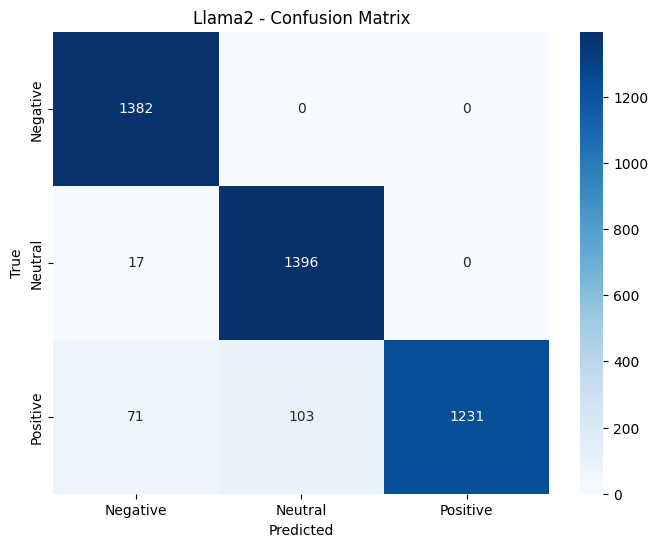

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming valid_true_sentiments and valid_predicted_sentiments are already defined

# Calculate the confusion matrix
conf_matrix = confusion_matrix(valid_true_sentiments, valid_predicted_sentiments)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Llama2 - Confusion Matrix')
plt.show()